![](cat_glass.png)

Deel 2 van het motie-onderzoek! We kijken naar de onderwerpen waar de ingediende moties van afgelopen Kamerperiode over gaan. [Top2Vec](https://github.com/ddangelov/Top2Vec) is een algoritme dat de moties kan clusteren naar onderwerp. Voor deze post heb ik uiteindelijk 14 onderwerpen gebruikt.

In [39]:
#| include: false
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import math
import altair as alt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [40]:
#| include: false
DATA_DIR = Path('data')
def load(filename):
    f = open(DATA_DIR/filename,"rb")
    return pickle.load(f)
    
def save(data, filename):
    with open(DATA_DIR/filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

from parameters import party_colors, parties, party_size


In [41]:
#| include: false
def get_stem_column(largest):
    return [c for c in df.columns if 'Stem_' in c and c != 'Stem_persoon' and c[5:] in largest]

def postprocess_chart(chart, hw=(200,300)):
    chart = chart.configure_axis(
        grid=False).configure_view(
        strokeWidth=0)
    if hw:
        chart.properties(width=hw[1], height=hw[0])
    return chart

def normalize(df, field, on='Aantal'):
    sums = df.groupby(field)[on].transform('sum')
    df[on] = df[on].div(sums)
    return df

def rankify(df, field, on='Aantal', num=4):
    df['Rank'] = df.groupby(field)[on].rank("min", ascending=False)
    df.loc[df['Rank'] > num, 'Rank'] = ''
    return df

In [42]:
#| include: false
df = load('df_including_topics_full.pickle')
df['Topic'].unique()

array(['Financien', 'Veiligheid', 'Asiel', 'Belasting', 'Onderwijs',
       'Arbeid', 'Infrastructuur & water', 'Europa', 'Klimaat',
       'Jeugdzorg', 'Landbouw & milieu', 'Wonen', 'Migratie',
       'Gezondheidszorg'], dtype=object)

In [43]:
#| include: false

# ## Welk soort onderwerpen staan op de agenda?
# Eerst kijken we naar de ontwikkeling van de onderwerpen van de ingediende moties. We weten al dat het absoluut aantal moties stijgt, dus heb ik gekeken naar de relatieve verdeling van de onderwerpen.


# df.groupby(['Jaar', 'Topic']).size().unstack(fill_value=0)
source = df.groupby(['Kamer', 'Topic']).size().reset_index(name='Aantal moties')

# Overview of topic distribution over all years
chart = alt.Chart(source).mark_bar().encode(
    x='Kamer:O',
    y=alt.Y('Aantal moties:Q', stack='normalize',axis=alt.Axis(format='%')),
    color=alt.Color('Topic:N'),
    # sort=alt.EncodingSortField('Aantal moties', order='descending'))
    # order=alt.Order('Aantal moties:Q',sort='descending')
    tooltip = 'Topic'
)
postprocess_chart(chart, (200,250))
# Opvallend dat de verhoudingen redelijk stabiel zijn! Je ziet dat in de loop van de tijd klimaat en energie, milieu en regelgeving (heel veel coronaregels zitten hier ook in gecategoriseerd), sociale zaken en wonen omhoog gaan. Omlaag gaan landbouw en dierenwelzijn, natuur en gaswinning, onderwijs en openbaar vervoer. Binnen de onderwerpen zijn natuurlijk wel verschuivingen waar het precies over gaat. We onderzoeken nu de ingediende moties tijdens de afgelopen Tweede Kamer periode.

alt.Chart(...)

## Meest actieve partijen per onderwerp
We onderzoeken welke partijen het meest actief en succesvol zijn door op drie manieren naar de data te kijken:

1. Aantal ingediende moties (per partij per onderwerp)
2. Aantal succesvolle moties
3. Aantal succesvolle moties per zetel

In [62]:
#| echo: false
source = df[(df['Kamer'] == 'Rutte IV') & (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Aantal')
source = rankify(source, 'Topic')
base = alt.Chart(source)
chart = base.mark_rect().encode(
    alt.X('Indienende_partij:N',title=None),
    alt.Y('Topic:N', title='Onderwerp'),
    color=alt.Color("Aantal:Q", 
                      scale = alt.Scale(scheme="greens")),
)
text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Indienende_partij:N'),
    alt.Y('Topic:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

In bovenstaande grafiek zien we bijvoorbeeld dat op de PvdD de meeste moties indient op Landbouw & Milieu, gevolgd door BBB, D66 en GroenLinks. De standpunten van de partijen kunnen natuurlijk verschillen!

PVV dient veel moties in op het gebied van asiel. Terwijl de SP op meerdere onderwerpen op 1 staat. Maar ingediend is niet hetzelfde als aangenomen:

In [66]:
#| echo: false
source = df[(df['Kamer'] == 'Rutte IV') & (df['BesluitSoort'] == 1)& (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Aantal')
source = rankify(source, 'Topic')
base = alt.Chart(source)
chart = base.mark_rect().encode(
    alt.X('Indienende_partij:N',title=None),
    alt.Y('Topic:N', title='Onderwerp'),
    color=alt.Color("Aantal:Q", title='Aantal succesvol',
                      scale = alt.Scale(scheme="greens")),
)
text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Indienende_partij:N'),
    alt.Y('Topic:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Wat betreft het aantal succesvolle moties dan zien we daar ineens vier partijen bovendrijven: CDA, ChristenUnie, D66 en VVD. De regeringspartijen, dat is logisch want die hebben een meerderheid. 
Nu kijken we naar het aantal succesvolle moties **per zetel**

In [47]:
#| include: false
aantal_moties = df.groupby(['Kamer','Indienende_partij', 'Topic']).count()['Titel'].reset_index()
aantal_moties.rename(columns={'Titel':'aantal'}, inplace=True)
aantal_succesvol = df[df['BesluitSoort']==1].groupby(['Kamer','Indienende_partij','Topic']).count()['Titel'].reset_index()
aantal_succesvol.rename(columns={'Titel':'aantal_succesvol'}, inplace=True)
max_votes_per_party = df[(['Aantal_stemmen_'+p for p in parties]+['Kamer'])].groupby('Kamer').quantile(.95)
max_votes_per_party = pd.melt(max_votes_per_party, ignore_index=False).reset_index()
max_votes_per_party = max_votes_per_party.rename(columns={'variable':'Indienende_partij', 'value':'num_votes'})
max_votes_per_party['Indienende_partij'] = max_votes_per_party['Indienende_partij'].str[15:]
stats = aantal_moties.merge(max_votes_per_party).merge(aantal_succesvol)

stats['aantal_zetel'] = stats['aantal'] /stats['num_votes']
stats['aantal_succesvol_zetel'] = stats['aantal_succesvol'] /stats['num_votes']
stats.head()

,Kamer,Indienende_partij,Topic,aantal,num_votes,aantal_succesvol,aantal_zetel,aantal_succesvol_zetel
0,Rutte IV,BBB,Arbeid,18,1.0,4,18.0,4.0
1,Rutte IV,BBB,Asiel,4,1.0,3,4.0,3.0
2,Rutte IV,BBB,Belasting,6,1.0,3,6.0,3.0
3,Rutte IV,BBB,Europa,38,1.0,11,38.0,11.0
4,Rutte IV,BBB,Financien,11,1.0,5,11.0,5.0


In [69]:
#| echo: false
source = stats[stats['Kamer']=='Rutte IV'].reset_index()
source = rankify(source, 'Topic', on='aantal_succesvol_zetel')
base = alt.Chart(source)

chart = base.mark_rect().encode(
    alt.X('Indienende_partij:N', title=None),
    alt.Y('Topic:N', title='Onderwerp'),
    color=alt.Color("aantal_succesvol_zetel:Q", title='Aantal succesvol/zetel',
                      scale = alt.Scale(scheme="greens"))
)

text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Indienende_partij:N'),
    alt.Y('Topic:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Dit overzicht geeft weer hoeveel succesvolle moties een partij er doorheen krijgt per onderwerp per zetel. Het is weer een heel ander beeld: partijen als BBB, CU en DENK doen het goed. Dit zijn natuurlijk ook partijen met weinig zetels.

In [49]:
#| include: false
df[(df['Indienende_partij']=='PvdA') & (df['Kamer'] == 'Rutte IV') & (df['BesluitSoort'] == 1) & (df['Topic'] == 'Sociale zaken')]['Indiener_persoon'].value_counts()

Series([], Name: count, dtype: int64)

## Waar richten de partijen zich op?
In bovenstaande grafieken hebben we de partijen onderling vergeleken. Nu kijken we **per partij** op welk vlak ze het meest actief zijn

In [50]:
#| include: false
#normalized version
source = df[(df['Kamer'] == 'Rutte IV') & (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Percentage')
source = normalize(source, 'Indienende_partij', on='Percentage')
source = rankify(source, 'Indienende_partij', on='Percentage', num=3)
source = source[source['Rank']!='']

In [51]:
#| echo: false
base = alt.Chart(source)
chart = base.mark_circle().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    size=alt.Size('Percentage:Q', scale=alt.Scale(range=[0,500])),
    color=alt.Color("Indienende_partij", 
                      scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties])),
)

text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Als een partij een hele grote bol heeft betekent dit dat de partij zich heel erg richt op dit onderwerp. Zijn er geen grote bollen binnen een partij is de inzet meer over de onderwerpen verspreid.
Europa, Landbouw en Milieu en Veiligheid krijgen bij veel partijen veel aandacht.

In [52]:
#| include: false
aantal_moties = df.groupby(['Kamer','Indienende_partij', 'Topic']).count()['Titel'].reset_index()
aantal_moties.rename(columns={'Titel':'aantal'}, inplace=True)
aantal_succesvol = df[df['BesluitSoort']==1].groupby(['Kamer','Indienende_partij','Topic']).count()['Titel'].reset_index()
aantal_succesvol.rename(columns={'Titel':'aantal_succesvol'}, inplace=True)
max_votes_per_party = df[(['Aantal_stemmen_'+p for p in parties]+['Kamer'])].groupby('Kamer').quantile(.95)
max_votes_per_party = pd.melt(max_votes_per_party, ignore_index=False).reset_index()
max_votes_per_party = max_votes_per_party.rename(columns={'variable':'Indienende_partij', 'value':'num_votes'})
max_votes_per_party['Indienende_partij'] = max_votes_per_party['Indienende_partij'].str[15:]
stats = aantal_moties.merge(max_votes_per_party).merge(aantal_succesvol)

stats['aantal_zetel'] = stats['aantal'] /stats['num_votes']
stats['aantal_succesvol_zetel'] = stats['aantal_succesvol'] /stats['num_votes']
stats.head()

,Kamer,Indienende_partij,Topic,aantal,num_votes,aantal_succesvol,aantal_zetel,aantal_succesvol_zetel
0,Rutte IV,BBB,Arbeid,18,1.0,4,18.0,4.0
1,Rutte IV,BBB,Asiel,4,1.0,3,4.0,3.0
2,Rutte IV,BBB,Belasting,6,1.0,3,6.0,3.0
3,Rutte IV,BBB,Europa,38,1.0,11,38.0,11.0
4,Rutte IV,BBB,Financien,11,1.0,5,11.0,5.0


In [53]:
#| include: false
# this is not normalized yet!

def get_party_chart(source, partij, axis=True):
    source = source.groupby(['Kamer', 'Topic']).size().reset_index(name='Aantal moties')
    source = normalize(source, field='Kamer', on='Aantal moties')
    source = rankify(source, field='Kamer', on='Aantal moties')

    # Overview of topic distribution over all years
    import altair as alt
    if axis:
        chart = alt.Chart(source).mark_rect().encode(
        y=alt.Y('Topic:N'),
        x=alt.X('Kamer:O',axis=alt.Axis(title=partij)),
        color = alt.Color('Aantal moties:Q',scale = alt.Scale(scheme="greens"), legend=None),
        tooltip = 'Topic')
    else:
        chart = alt.Chart(source).mark_rect().encode(
        y=alt.Y('Topic:N', axis=None),
        x=alt.X('Kamer:O',axis=alt.Axis(title=partij)),
        color = alt.Color('Aantal moties:Q',scale = alt.Scale(scheme="greens"), legend=None),
        tooltip = 'Topic')
    text = alt.Chart(source).mark_text().encode(
        y=alt.Y('Topic:N'),
        x='Kamer:O',
        text=alt.Text('Rank:N'))
    return chart + text

legend = [False] * len(parties)
legend[0] = True
charts = [get_party_chart(df[df['Indienende_partij'] == partij], partij, legend[i]) for i, partij in enumerate(parties)]

#| include: false
import altair as alt
alt.hconcat(*charts)

alt.HConcatChart(...)

## Stemgedrag per onderwerp
Dan toch nog eens proberen het stemgedrag te visualiseren. Als de BBB iets indient voor Landbouw & Milieu betekent dit heel iets heel anders dan als de PvdD dat doet. In onderstaande plots staat per onderwerp het stemgedrag gevisualiseerd. Positief of negatief zegt niets, het gaat om partijen die dichtbij of ver weg van elkaar staan. PvdD en VVD vormen meestal de uitersten en verschillen dus het meeste op stemgedrag. Deze grafieken verklaren meestal zo'n 35%-55% van de variatie in het stemgedrag. Let op: het is dus een enorme versimpeling van de werkelijkheid!

In [86]:
#| include: false

    
def get_pca(df, n_components=1, num_largest=None, return_ratio=False, verbose=True):
    largest = parties
    stem_column = get_stem_column(largest)
    source_year = df[stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='most_frequent').fit_transform(source_year)
    pca = PCA(n_components = n_components)
    pca = pca.fit(X_year)
    if verbose: print('explained variance by factors', pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
    res_year = pca.transform(X_year)
    source = pd.DataFrame(res_year)
    source['partij'] = source_year.T.columns.str[5:]
    source = source.rename(index=str, columns={0: "x", 1: "y"}).sort_values('x',ascending=False)
    return (source, pca.explained_variance_ratio_) if return_ratio else source

In [93]:
#| include: false


def pca_topic(df, topic, kamer, twodim=False, size=800, verbose=True):
    column_list = df.columns
    source = df[(df['Topic'] == topic) & (df['Kamer'] == kamer)]
    num_moties = len(source)
    if twodim:
        source, explained_variance_ratio_ = get_pca(source, n_components = 2, return_ratio=True, verbose=verbose)
    else:
        source, explained_variance_ratio_ = get_pca(source, n_components = 1, return_ratio=True, verbose=verbose)
    mid = (source['x'].max() + source['x'].min())/2
    median = source['x'].median()
    if source[source['partij'] =='FVD']['x'].values > median: # make sure that VVD is on the right part of the x-axis
        source['x'] += 2 * (mid - source['x'])
    if twodim:
        points = alt.Chart(source,width= size * explained_variance_ratio_[0],height = size * explained_variance_ratio_[1]).mark_point().encode(
        # x=alt.X('x:Q', axis=alt.Axis(title='Eerste factor')),
        # y=alt.Y('y:Q', axis=alt.Axis(title='Tweede factor')),
        x=alt.X('x:Q', axis=None),
        y=alt.Y('y:Q', axis=None),
        color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
        tooltip=['partij:N']
        )

        text = points.mark_text(
            align='left',
            baseline='middle',
            dx=np.random.uniform(0,10),
            dy=np.random.uniform(0,10)
            # opacity=0.5
        ).encode(
            text='partij:N'
        ).properties(
            title='Welke partijen lijken op elkaar'
        )

        return (points + text).configure_axis(
            grid=False).configure_view(
            strokeWidth=1)
        
    else:
        chart = alt.Chart(source,width=size/4,height = size/16).mark_bar().encode(
        x=alt.X('partij:N',sort=alt.SortField(field="x", order='descending')),
        y=alt.Y('x:Q', axis = None),
        color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
    )
        chart.encoding.x.title = f'{topic} #{num_moties} {round(explained_variance_ratio_[0]*100)}%'
        
        return chart

In [94]:
#| include: false
topics = df[df['Kamer']=='Rutte IV'].groupby('Topic').size().sort_values(ascending=False).index
for topic in topics:
    print(topic, end=' ')
    pca_topic(df, topic, 'Rutte IV', twodim=True)

Veiligheid explained variance by factors [0.34038661 0.20579196] 0.5461785710404274
Klimaat explained variance by factors [0.41103518 0.20422953] 0.6152647132914568
Gezondheidszorg explained variance by factors [0.36816114 0.20926791] 0.5774290510541172
Europa explained variance by factors [0.40289209 0.15108397] 0.5539760548031801
Landbouw & milieu explained variance by factors [0.46052213 0.16223423] 0.6227563591090721
Infrastructuur & water explained variance by factors [0.37420779 0.17614115] 0.5503489393213952
Financien explained variance by factors [0.32483235 0.22577118] 0.5506035346850048
Arbeid explained variance by factors [0.36478303 0.23979934] 0.604582375280896
Onderwijs explained variance by factors [0.32055504 0.23166176] 0.5522168018471485
Migratie explained variance by factors [0.45152388 0.16092068] 0.6124445686702034
Asiel explained variance by factors [0.42536268 0.17874023] 0.6041029102677293
Jeugdzorg explained variance by factors [0.35446564 0.22249719] 0.5769628

In [95]:
#| include: false
charts = [pca_topic(df, topic, 'Rutte IV') for topic in topics]

explained variance by factors [0.34038661] 0.3403866132545612
explained variance by factors [0.41103518] 0.41103518212305895
explained variance by factors [0.36816114] 0.3681611385472996
explained variance by factors [0.40289209] 0.40289208617993993
explained variance by factors [0.46052213] 0.4605221273350384
explained variance by factors [0.37420779] 0.37420778926251164
explained variance by factors [0.32483235] 0.3248323539086642
explained variance by factors [0.36478303] 0.3647830342624086
explained variance by factors [0.32055504] 0.32055504072116936
explained variance by factors [0.45152388] 0.451523884890521
explained variance by factors [0.42536268] 0.42536268442060393
explained variance by factors [0.35446564] 0.3544656439800834
explained variance by factors [0.32430905] 0.3243090532876076
explained variance by factors [0.35975791] 0.3597579141510727


In [96]:
#| include: false
n_rows = 4
column_charts = []
for cols in range(0,math.ceil(len(charts)/n_rows)):
    row_charts = [charts[cols*n_rows+rows] for rows in range(n_rows) if cols*n_rows+rows < len(charts)]
    column_charts.append(alt.hconcat(*row_charts))
alt.vconcat(*column_charts).configure_axis(
        grid=False).configure_view(
        strokeWidth=0)

alt.VConcatChart(...)

'#' geeft het aantal moties aan en '%' het percentage dat deze visualisatie verklaart. Meestal zien we hetzelfde patroon terug, een aantal keer zien we echt 'regering tegenover oppositie' (gezondheidszorg, arbeid, jeugdzorg en belasting).

## Stemgedrag op klimaat


Hieronder zie je het stemgedrag op klimaat. De afstand tussen de partijen geeft aan hoeveel ze verschillen. Hiermee kunnen we ~40% van het stemgedrag verklaren.

In [97]:
#| echo: false
pca_topic(df, 'Klimaat', 'Rutte IV', False, size=1200, verbose=False)

alt.Chart(...)

Als we er nog een tweede as bij zetten kunnen we 60% van de variatie verklaren.

In [98]:
#| echo: false

cutoffdate = '2023-12-01 00:00:00'
cutoffstartdate = '2021-11-01 00:00:00'
date64 = np.datetime64(cutoffdate)
# df[df['GestartOp']]<cutoffdate

pca_topic(df, 'Klimaat', 'Rutte IV', True, size= 900, verbose=False)


alt.LayerChart(...)

Vooral voor Omtzigt gaat het heel interessant worden wat de standpunten zijn ten opzichte van klimaat. Dit zou zomaar eens kunnen bepalen welke kant het beleid op gaat kantelen.


In [ ]:
#| include: false

# ## Onderzoek naar klimaat
# Omdat ik denk dat klimaat de grootste uitdaging is voor de mensheid heb ik hier de subonderwerpen nog eens doorgenomen. Natuur en milieu zijn natuurlijk ook heel erg belangrijke onderwerpen, maar toch besloten het even bij het klimaat te houden.
# source = df[(~df['Klimaat'].isnull()) & (df['Kamer']=='Rutte IV')]
# source = source.groupby(['Klimaat','Indienende_partij']).size().reset_index(name='Aantal')
# chart = alt.Chart(source).mark_bar().encode(
#     x=alt.X('Indienende_partij:O', sort=alt.EncodingSortField(field="Aantal", op="sum", order='descending')),
#     y=alt.Y('Aantal:Q'),
#     color=alt.Color('Klimaat:N'),
#     tooltip = 'Klimaat:O'
# ).properties(title='Aantal ingediende moties')

# source = df[(~df['Klimaat'].isnull()) & (df['Kamer']=='Rutte IV') & df['BesluitSoort']==1]
# source = source.groupby(['Klimaat','Indienende_partij']).size().reset_index(name='Aantal')
# chart2 = alt.Chart(source).mark_bar().encode(
#     x=alt.X('Indienende_partij:O', sort=alt.EncodingSortField(field="Aantal", op="sum", order='descending')),
#     y=alt.Y('Aantal:Q'),
#     color=alt.Color('Klimaat:N'),
#     tooltip = 'Klimaat:O'
# ).properties(title='Aantal succesvolle moties')

# postprocess_chart(chart | chart2, hw=None)

Voor alle onderwerpen heb ik [de MotieMachine](https://stemvinder.ew.r.appspot.com/) gemaakt. Hier staan alle 72 onderwerpen in, inclusief een mogelijkheid om de moties door te lezen. Veel plezier ermee!

## Bijlage 1: alle 72 onderwerpen die in de motiemachine staan

* ['landbouwbeleid' 'landbouw' 'landbouwsector' 'landbouwgronden'], 479 moties
* ['europe' 'europees' 'eurolanden' 'europa'], 371 moties
* ['onderwijsaanbod' 'basisonderwijs' 'onderwijsveld' 'onderwijsroute'], 347 moties
* ['cyberveiligheid' 'onlineprivacy' 'veiligheidsraad' 'veiligheid'], 346 moties
* ['ziekenhuizen' 'verpleeghuizen' 'verpleegzorg' 'verpleeghuis'], 339 moties
* ['woningbouw' 'huizenprijzen' 'woningmarkt' 'huiseigenaren'], 283 moties
* ['klimaatbeleid' 'klimaatakkoord' 'klimaatakoord' 'klimaatcrisis'], 244 moties
* ['treinverkeer' 'treinverbinding' 'spoorwegen' 'verkeersdoden'], 241 moties
* ['jeugdzorgplus' 'jeugdbecherming' 'jeugdbeschermer' 'jeugdzorg'], 237 moties
* ['vaccinatiegraad' 'vaccinatie' 'vaccinaties' 'vaccineren'], 226 moties
* ['vluchtelingen' 'migranten' 'vluchteling' 'immigratie'], 202 moties
* ['amnesty' 'oversterfte' 'overschreden' 'overweging'], 180 moties
* ['milieuwetgeving' 'milieubeheer' 'milieugrondslag' 'milieuschade'], 172 moties
* ['waterbeleid' 'waterveiligheid' 'hervatten' 'grondwater'], 169 moties
* ['herstelfonds' 'burgerbudgetten' 'wijzigingen' 'systeemkosten'], 168 moties
* ['arbeidsmarkt' 'werkgelegenheid' 'arbeidstekorten' 'arbeidsmiranten'], 167 moties
* ['belastingwetten' 'belastingen' 'tax' 'belasting'], 161 moties
* ['economische' 'economisch' 'economic' 'econoische'], 159 moties
* ['volksgezondheid' 'sporthulpmiddel' 'gezondheidszorg' 'gezondheid'], 154 moties
* ['strafrechtketen' 'strafrechtelijk' 'gevangenisstraf' 'strafrecht'], 150 moties
* ['minimuminkomen' 'minimumloon' 'armoedegrens' 'minimaliseren'], 149 moties
* ['politiewerk' 'politieagenten' 'politiebureau' 'politiebureaus'], 141 moties
* ['dierenwelzijn' 'dierenleed' 'dieren' 'huisdieren'], 140 moties
* ['luchthaven' 'vliegveld' 'luchthavens' 'airport'], 131 moties
* ['cultuursector' 'cultuurbeleid' 'cultuur' 'cultureel'], 118 moties
* ['pensioenstelsel' 'pensioenwet' 'pensioenopbouw' 'pensioenakkoord'], 114 moties
* ['industriebeleid' 'bordstrategie' 'strategische' 'strategisch'], 112 moties
* ['maatschappelijk' 'gerechtshof' 'sociale' 'hof'], 110 moties
* ['europees' 'europe' 'eurolanden' 'europa'], 104 moties
* ['rijksbeleid' 'taxibeleid' 'erfpachtbeleid' 'economiebeleid'], 103 moties
* ['energieprijzen' 'energiekosten' 'energiecrisis' 'energieverbruik'], 102 moties
* ['sporthulpmiddel' 'sportbeleid' 'sportvereniging' 'sport'], 98 moties
* ['gaswinning' 'gasvelden' 'gasopslag' 'gasveld'], 96 moties
* ['gepensioneerden' 'pensioenopbouw' 'ouderen' 'ouderenzorg'], 92 moties
* ['onderzeeboten' 'seaports' 'zeegebieden' 'zee'], 90 moties
* ['russische' 'russisch' 'europees' 'europe'], 89 moties
* ['gasprijzen' 'gasopslag' 'gasnetwerk' 'gasopslagen'], 88 moties
* ['biobrandstoffen' 'biomassa' 'ecoregelingen' 'biobrandstof'], 87 moties
* ['racisme' 'discrimiatie' 'discriminatie' 'racistische'], 87 moties
* ['ouders' 'belastingdienst' 'familierecht' 'belastingschuld'], 87 moties
* ['verpleeghuizen' 'ziekenhuizen' 'ziekenhuiszorg' 'verpleeghuis'], 78 moties
* ['militaire' 'militairen' 'soldaten' 'krijgsmacht'], 74 moties
* ['inflatie' 'inflation' 'bufferstroken' 'buffers'], 74 moties
* ['afghaanse' 'afghanistan' 'talibanregime' 'afghanen'], 73 moties
* ['belastingdienst' 'belastingwetten' 'belastingienst' 'belastingen'], 72 moties
* ['jeugdzorgplus' 'jeugdbecherming' 'jeugdbeschermer' 'jeugdzorg'], 71 moties
* ['klimaatcrisis' 'economische' 'economic' 'klimaatakoord'], 71 moties
* ['mediabeleid' 'journalisten' 'journalist' 'media'], 70 moties
* ['taalonderwijs' 'onderwijsaanbod' 'afstuderen' 'afgestudeerden'], 69 moties
* ['energiecrisis' 'energiebeleid' 'energiekosten' 'klimaatbeleid'], 66 moties
* ['waterbeleid' 'energiebeleid' 'productiewater' 'waterveiligheid'], 66 moties
* ['verkrachting' 'verkracht' 'seksualiteit' 'prostitutie'], 64 moties
* ['financieren' 'financiering' 'financieringen' 'financien'], 63 moties
* ['belastingen' 'winstbelasting' 'tax' 'belasting'], 63 moties
* ['palestijnen' 'palestijns' 'palestijnse' 'israeli'], 57 moties
* ['bankrekening' 'bank' 'volksbank' 'banken'], 55 moties
* ['onderwijsaanbod' 'onderwijsroute' 'educatie' 'onderwijs'], 54 moties
* ['recycling' 'recyclebaar' 'recyclen' 'recyclaat'], 53 moties
* ['maatschappelijk' 'sociale' 'arbeidsmiranten' 'arbeidstekorten'], 53 moties
* ['zonnepanelen' 'zonnepaelen' 'energiebeleid' 'zonnestroom'], 52 moties
* ['china' 'chinese' 'exitstrategie' 'bordstrategie'], 51 moties
* ['kernenergie' 'nuclear' 'nucleaire' 'kerncentrales'], 49 moties
* ['foreign' 'buitenlands' 'buitenland' 'buitengrenzen'], 46 moties
* ['kredietcrisis' 'schuldenaanpak' 'kredietregister' 'schulden'], 45 moties
* ['vogelgriepvirus' 'vogelgriep' 'vogels' 'vogelpest'], 43 moties
* ['klimaatfonds' 'omgevingsfonds' 'warmtefonds' 'noodfonds'], 43 moties
* ['vuurwerkverbod' 'brandweerzorg' 'brandweerlieden' 'vuurwerk'], 40 moties
* ['gascrisis' 'gasprijzen' 'broeikasgassen' 'gasopslagen'], 38 moties
* ['drugscriminelen' 'drugbeleid' 'drugsgebruik' 'drugssmokkel'], 38 moties
* ['abortuszorg' 'abortussen' 'abortus' 'zwangerschap'], 37 moties
* ['terrorisme' 'terroristische' 'terroristen' 'terroristisch'], 36 moties
* ['indonesische' 'indonesie' 'nederlanders' 'oorlogsmisdaden'], 36 moties
* ['buitengrenzen' 'buitengrens' 'buitenlucht' 'out'], 32 moties
* ['koning' 'koningshuis' 'koninklijk' 'koninklijke'], 31 moties
* ['landbouwbeleid' 'actieprogramma' 'landbouwsector' 'programma'], 30 moties
* ['groenregeling' 'groenprojecten' 'milieugrondslag' 'ecoregelingen'], 28 moties
* ['sigaretten' 'sigaret' 'roken' 'tabaksproducten'], 28 moties
* ['algoritmes' 'algoritme' 'algoritmen' 'gedragscode'], 27 moties
* ['syrische' 'vluchtelingen' 'vluchteling' 'syriers'], 27 moties
* ['iraanse' 'iran' 'europees' 'eurolanden'], 26 moties
* ['kansspelen' 'loterijen' 'loterij' 'risico'], 25 moties
* ['taxichauffeurs' 'taxibeleid' 'taxi' 'taxibranche'], 21 moties

## Bijlage 2: Wordcloud van de 14 onderwerpen

In [100]:
#| include: false
from top2vec import Top2Vec
from scipy.special import softmax
import matplotlib.pyplot as plt
from wordcloud import WordCloud

model = Top2Vec.load("data/doc2vec_deep_bigram_enhanced_stopwords_rutteIV_reduced")
topic_words, word_scores, topic_nums = model.get_topics(reduced=True)

d:\Programmeren\adventofcode\.aocenvpy311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\Programmeren\adventofcode\.aocenvpy311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\Programmeren\adventofcode\.aocenvpy311\Lib\site-packages\umap\distances.py:

In [101]:
#| include: false
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
def generate_topic_wordcloud(self, topic_num, background_color="black", reduced=False, text = None):
        """
        Create a word cloud for a topic.
        A word cloud will be generated and displayed. The most semantically
        similar words to the topic will have the largest size, less similar
        words will be smaller. The size is determined using the cosine distance
        of the word vectors from the topic vector.
        Parameters
        ----------
        topic_num: int
            The topic number to search.
        background_color : str (Optional, default='white')
            Background color for the word cloud image. Suggested options are:
                * white
                * black
        reduced: bool (Optional, default False)
            Original topics are used by default. If True the
            reduced topics will be used.
        Returns
        -------
        A matplotlib plot of the word cloud with the topic number will be
        displayed.
        """

        if reduced:
            self._validate_hierarchical_reduction()
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words_reduced[topic_num],
                                       softmax(self.topic_word_scores_reduced[topic_num])))
        else:
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words[topic_num],
                                       softmax(self.topic_word_scores[topic_num])))

        plt.figure(figsize=(4, 1),
                   dpi=400)
        plt.axis("off")
        plt.imshow(
            WordCloud(width=400,
                      height=100,
                      background_color=background_color).generate_from_frequencies(word_score_dict))
        plt.title(f'Onderwerp #{topic_num}, ingedeeld als: {text}', loc='left', fontsize=8, pad=1)
model.generate_topic_wordcloud = generate_topic_wordcloud

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_5784\4203032255.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


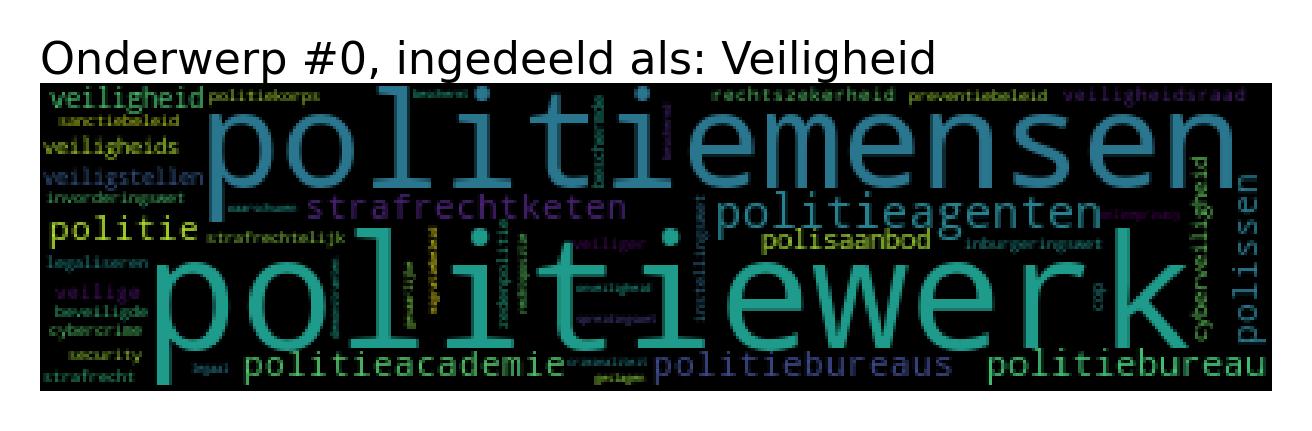

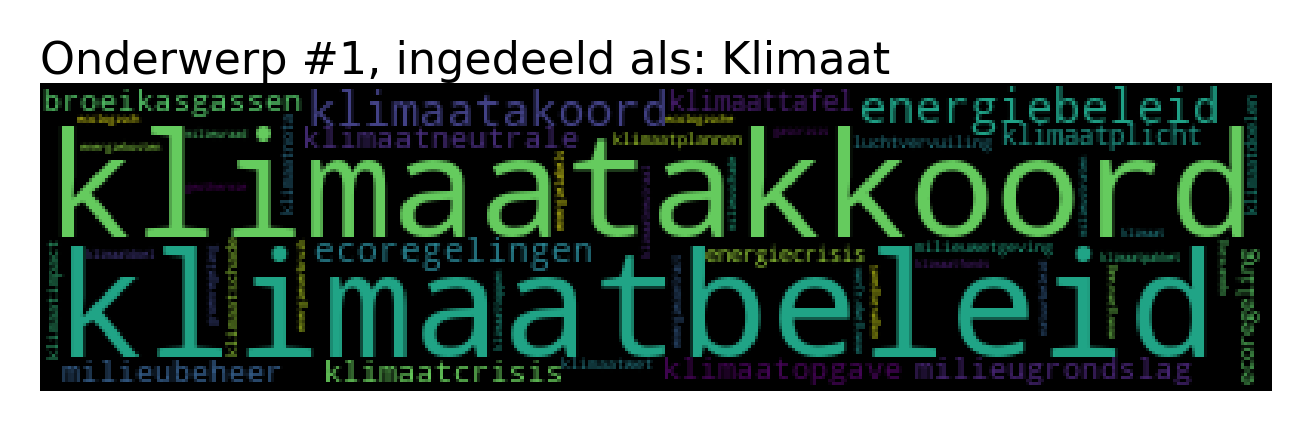

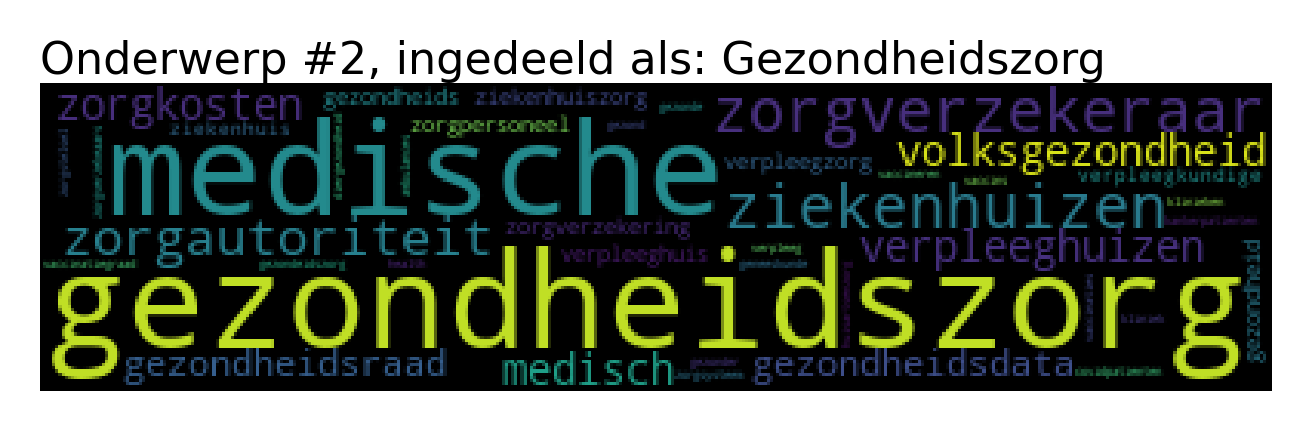

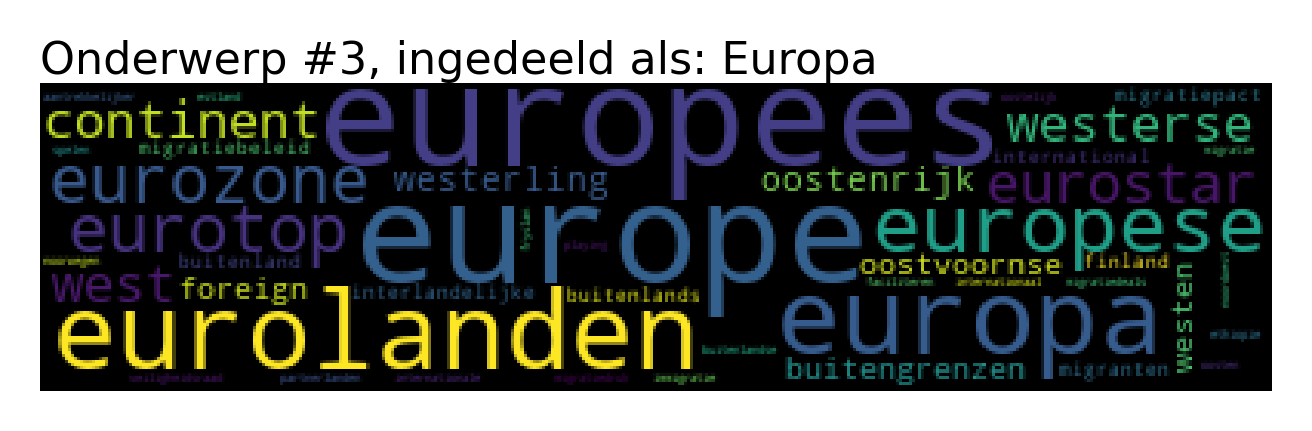

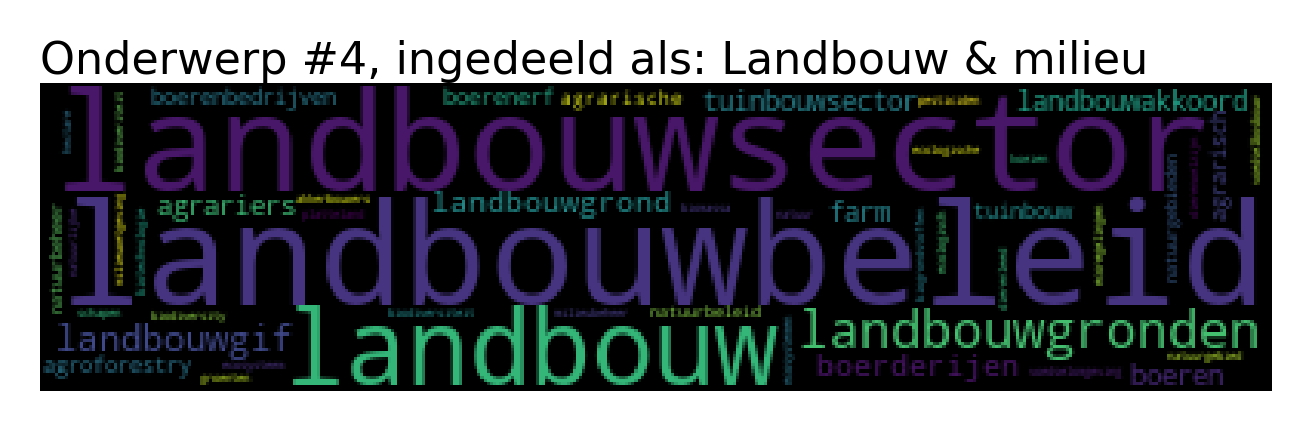

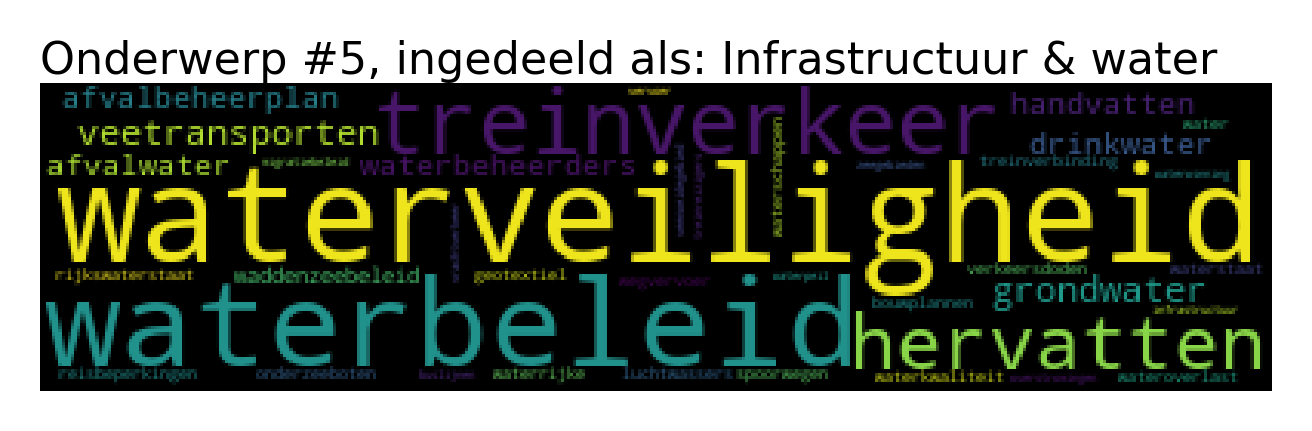

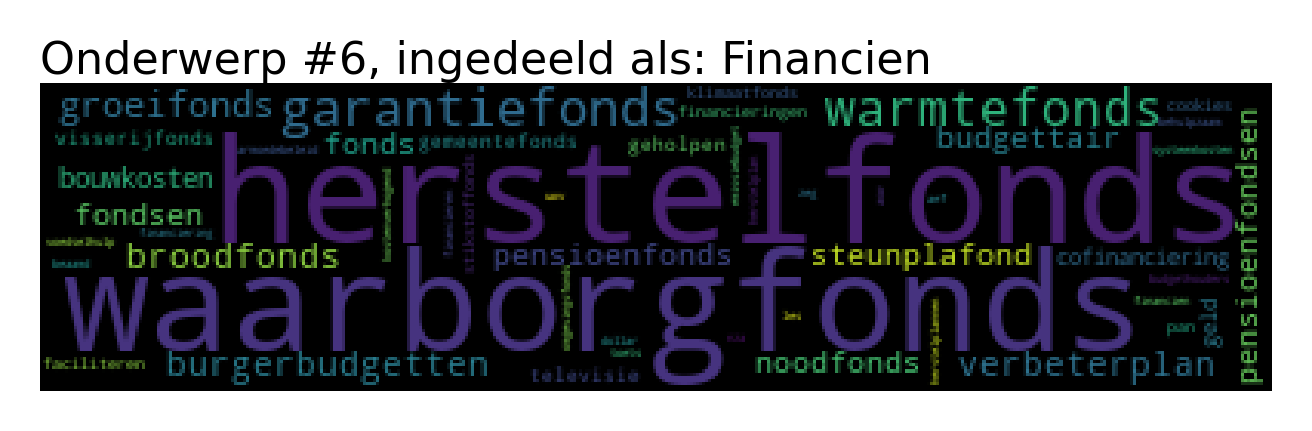

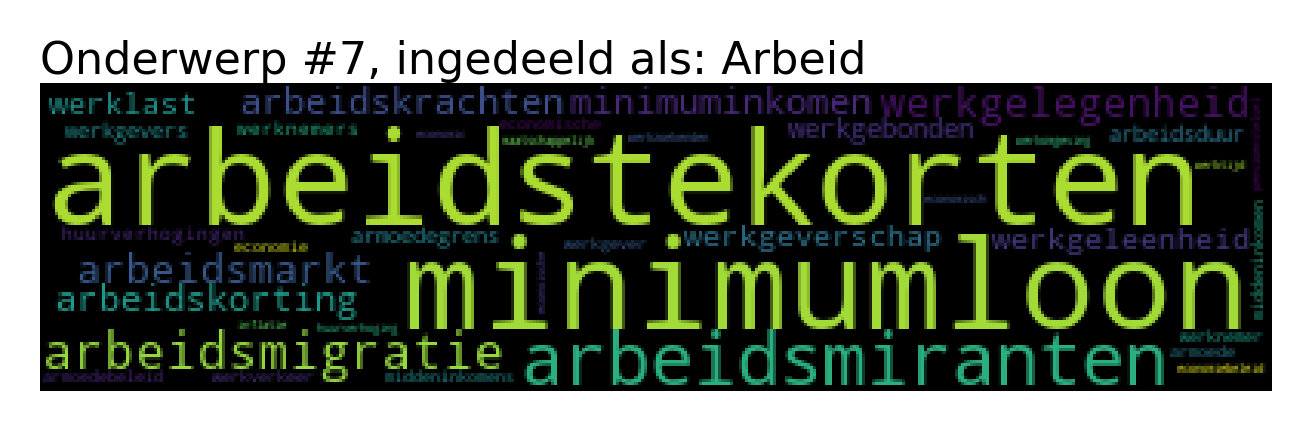

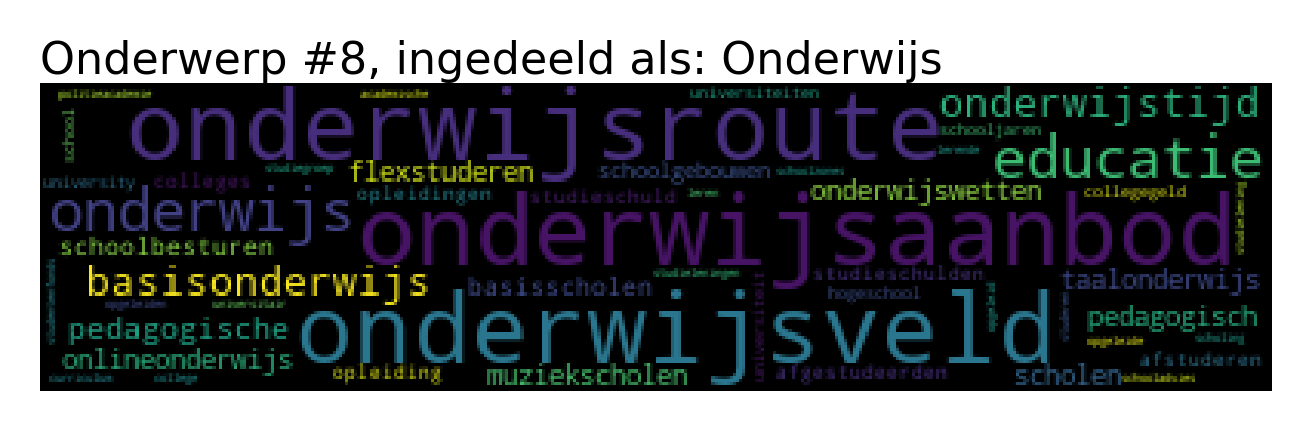

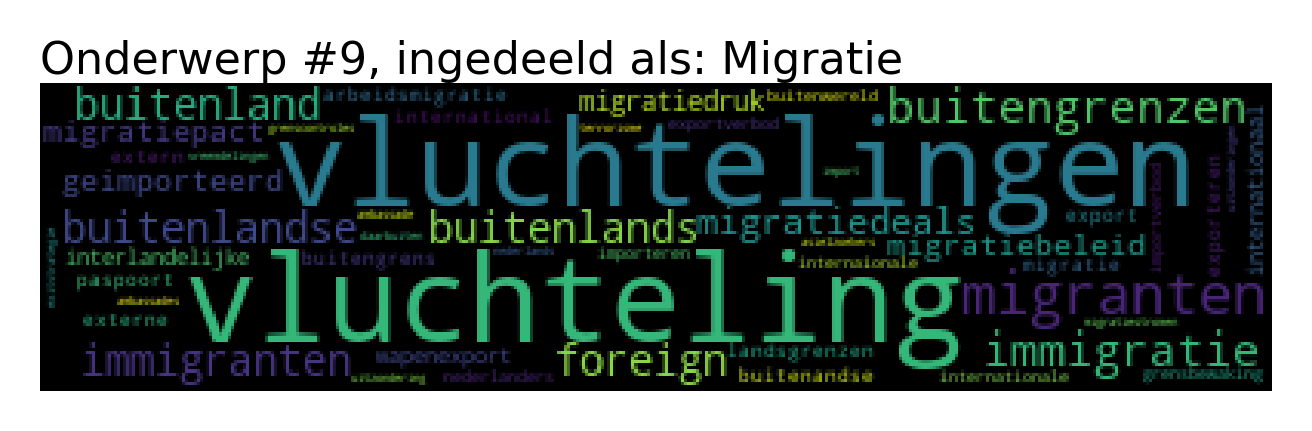

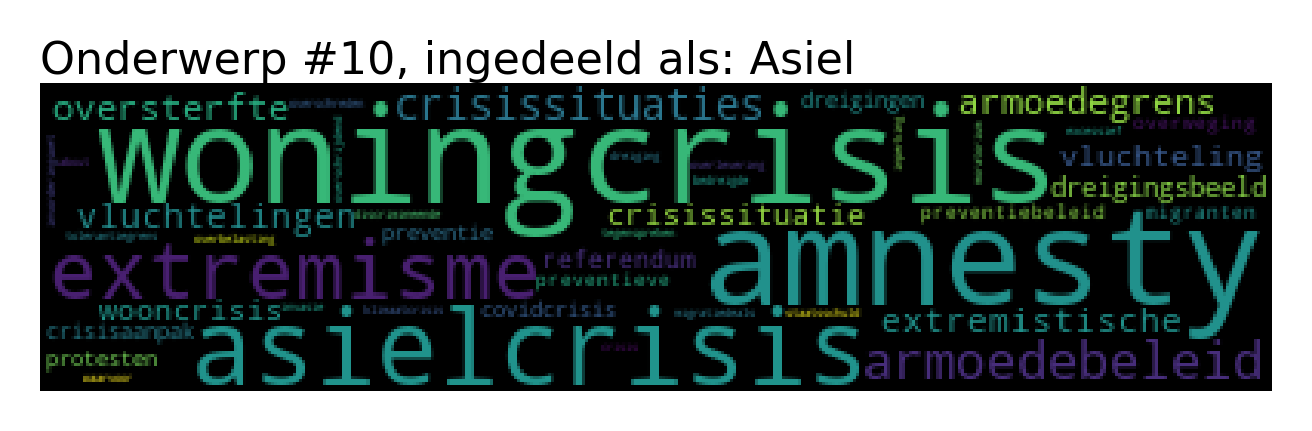

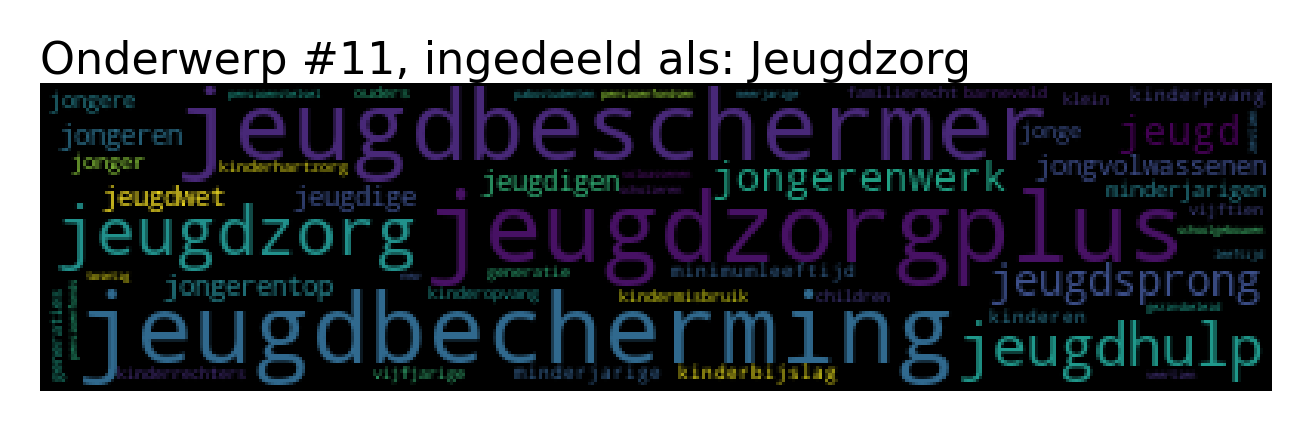

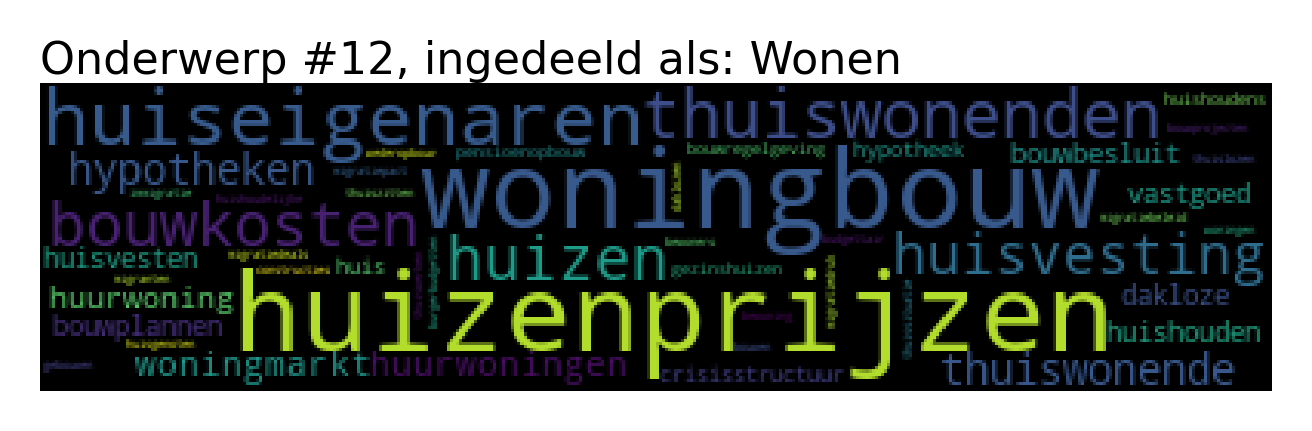

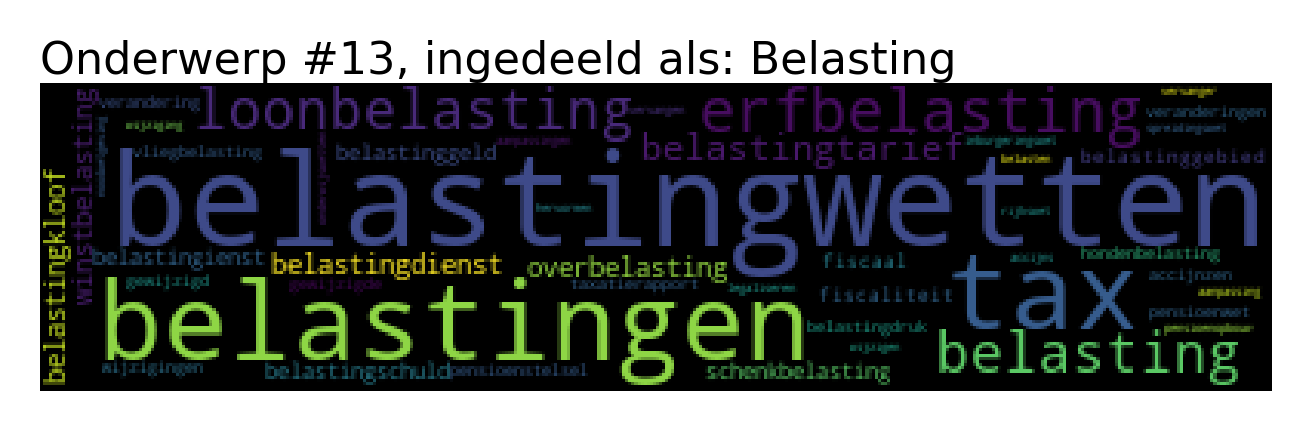

In [102]:
#| echo: false

topics = {
  0: 'Veiligheid',  
  1: 'Klimaat',  
  2: 'Gezondheidszorg',  
  3: 'Europa',  
  4: 'Landbouw & milieu',  
  5: 'Infrastructuur & water',  
  6: 'Financien',  
  7: 'Arbeid',  
  8: 'Onderwijs',  
  9: 'Migratie',  
  10: 'Asiel',  
  11: 'Jeugdzorg',  
  12: 'Wonen',  
  13: 'Belasting'
  }
for i, topic in enumerate(topic_words):
    # print(f'\nOnderwerp {i+1}, geclassificeerd als: {topics[i]}:\n{words}')
    model.generate_topic_wordcloud(model, topic_num = i, reduced=True, text = topics[i])